In [55]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [56]:
def Mean_Squared_Error(pred,y,squared=True):
    rmse = (1/np.size(y))*np.sum(pred-y)
    if (squared):
        return np.sqrt(rmse)
    return rmse
def Mean_Absolute_Error(pred,y):
    return (1/np.size(y))*abs(np.sum(pred-y))

def R2(pred,y):
    mean = np.mean(y)
    sum1 = sum2 = 0
    for i in range(np.size(pred)):
        sum1 += (y[i] - pred[i])**2
    for i in range(np.size(pred)):
        sum2 += (y[i] - mean)**2
    return abs(1 - (sum1/sum2))

## Regressão Linear
Releção estatistica entre dois atributos
* Problema separado linearmente
* Prever|Previsão um target

### Estatístico

$y = a\cdot x + b$ \
$a$:coefiente angular
> $a = \frac{\sum{xy}-\sum{x} \cdot {\sum{y}} }{\sum{x^2}-(\sum{x})²}$ 

$b$:interceptor  
> $b = media_y - a \cdot media_x$

In [57]:
apart = pd.read_csv(r'dataset/PreçoApartamento.csv')
apart.head(3)

,Apartamento,Metragem (m²),Preço (USD)
0,Apartamento 1,100,150000
1,Apartamento 2,75,120000
2,Apartamento 3,120,200000


In [58]:
x = apart[' Metragem (m²)']
y = apart[' Preço (USD)']

In [59]:
xy = pd.Series(data=x*y  ,name='xy')
xx = pd.Series(data=x**2 ,name='xx')

In [60]:
# coeficiente linear
a = ((len(xy)*np.sum(xy) - np.sum(x) * np.sum(y) )) / (len(xy)*np.sum(xx) - (np.sum(x)**2))
# interceptor
b = np.mean(y) - a*np.mean(x) 
a,b

(1683.1471357261707, -10345.495602567156)

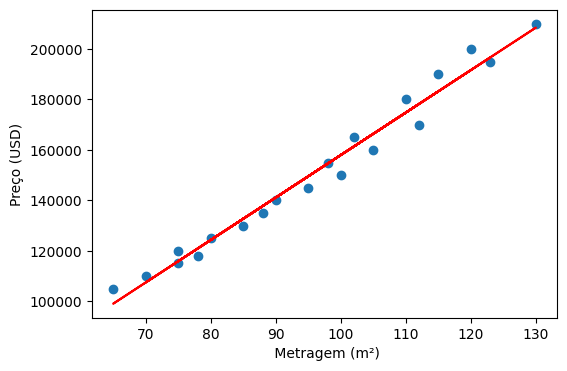

In [61]:
plt.figure(figsize=(6,4))
plt.scatter(x,y)
plt.plot(x,(a*x+b),'red')
plt.ylabel('Preço (USD)')
plt.xlabel(' Metragem (m²)')
plt.show()

Fazendo a previsão dos preços de um apartamento com 78 $m^2$ e com 32 $m²$

In [62]:
print('Preço para apartamento com 78 m²:'+str(a * 72 + b))
print('Preço para apartamento com 32 m²:'+str(a * 32 + b))

Preço para apartamento com 78 m²:110841.09816971714
Preço para apartamento com 32 m²:43515.21274067031


&nbsp;

### Machine learning

#### Predição do Modelo 
$$
\^{y} = \theta_0 + \theta_1x_1 + \theta_2x_2+...+\theta_nx_n
$$
* $\theta_n$ = são os parametro do modelo
    * $\theta_0$ : intercepto
    * $\theta_{n \geq i}$ : coeficiente linear
* $x_n$ = são as caracteristicas (atributo)
* $n$ = é quantidade de caracteristicas
* $\^{y}$ = valor previsto

#### Equação Normal
$$\^{\theta} = (X^T X)^{-1} X^T y$$

In [70]:
from typing       import Literal,_LiteralGenericAlias
from sklearn.base import RegressorMixin


class RegressaoLinear(RegressorMixin):
    theta = None
    def __init__(self,solver=Literal['simples','normal','svd']):
        if (type(solver)==_LiteralGenericAlias):
            self.solver = 'normal'
        else:
            self.solver = solver

    def fit(self,X:np.array, y:np.array):
        
        m = np.size(X)
        X = np.c_[ np.ones((m,1)) , X]

        match (self.solver):
            case 'normal':
                self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)     
        
            case 'simples': 
                xx = X[:,1]**2 ;xy = X[:,1]*y
                
                angular    = ((m*np.sum(xy) - np.sum(X[:,1]) * np.sum(y) )) / (m*np.sum(xx) - (np.sum(X[:,1])**2))
                intercepto =  np.mean(y) - angular*np.mean(X[:,1])
        
                self.theta = np.array([[intercepto],[angular]])
        
            case 'svd':
                U, S, Vt   = np.linalg.svd(X,full_matrices=False)
                self.theta = Vt.T @ np.linalg.inv(np.diag(S)) @ U.T @ y
            
        return self.theta
        
    
    def predict(self,X:np.array)->Literal['Valor y']:
        return (self.theta[1] * X ) + self.theta[0] # y = theta_0 + theta_1x1.....

In [71]:
salario = pd.read_csv(r'dataset/Salário.csv')

X = salario['Experiencia'].values.reshape(-1,1)
Y = salario['Salario'].values.reshape(-1,1)

xtrain , xtest ,ytrain , ytest = train_test_split(X,Y,random_state=42,train_size=45)

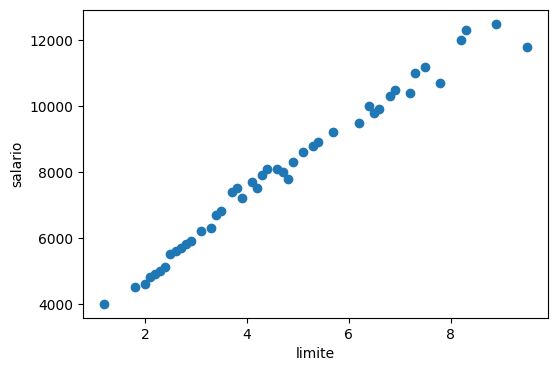

In [72]:
plt.figure(figsize=(6,4))
plt.scatter(xtrain,ytrain); plt.ylabel('salario');plt.xlabel('limite')
plt.show()

In [73]:
reg = RegressaoLinear('svd')
reg.fit(xtrain,ytrain)

array([[2847.01740378],
       [1085.98791782]])

array[0] = intercepto | coeficiente linear\
array[1] = coeficiente angular\
Função do modelo \
Vou querer valores de experiencia 3.5, 4

In [74]:
pred = reg.predict(xtest)

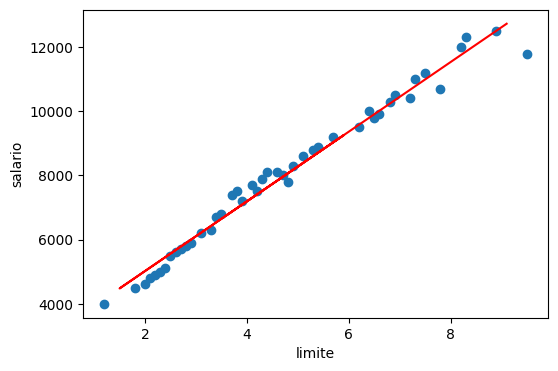

In [75]:
plt.figure(figsize=(6,4))
plt.scatter(xtrain,ytrain); 
plt.plot(xtest,pred,'red')
plt.ylabel('salario');plt.xlabel('limite')
plt.show()

### Gradiente descendente Batch

In [103]:
class GradienteBatch(RegressorMixin):
    def __init__(self , maxIter =1_000, eta = 0.1 , theta = np.random.randn(2,1)) :
        self.maxIter = maxIter
        self.eta     = eta
        self.theta   = theta 


    def condicao(self,vetor):
        if np.any(np.isinf(vetor)):   return True
        if np.any(np.isnan(vetor)):   return True
        if np.any(np.isneginf(vetor)):return True
        return False

    def fit(self,X,y):
        m = np.size(X)
        X = np.c_[ np.ones((m,1)) , X]
        for i in range(self.maxIter):
            gradienteMSE = ( X.T.dot(X.dot(self.theta) - y))
            gradienteMSE = 2/m * gradienteMSE
            
            if (self.condicao(gradienteMSE)):break

            self.theta   = self.theta - self.eta * gradienteMSE

            if(self.condicao(self.theta)):break

        return self.theta
    
    def predict(self,X):
        return self.theta[1] * X + self.theta[0]

In [243]:

from sklearn.preprocessing import StandardScaler

xtrain , xtest , ytrain , ytest = train_test_split(StandardScaler().fit_transform(x.reshape(-1,1)),y.reshape(-1,1),test_size=5)

In [244]:
GradBatch = GradienteBatch(eta=0.01,maxIter=10000)
GradBatch.fit(xtrain,ytrain)

array([[  1.06341055],
       [117.40881917]])

In [246]:
pred = GradBatch.predict(xtest)

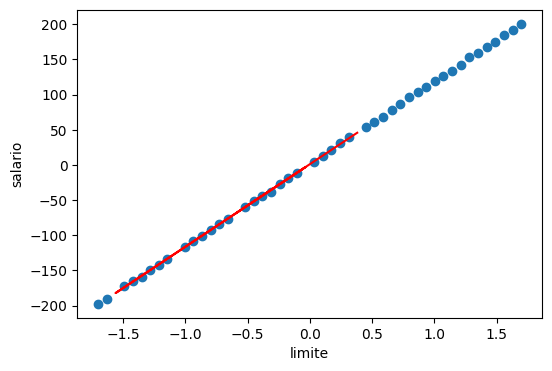

In [247]:
plt.figure(figsize=(6,4))
plt.scatter(xtrain,ytrain); 
plt.plot(xtest,pred,'red')
plt.ylabel('salario');plt.xlabel('limite')
plt.show()